In [76]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [70]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, linalg
from sklearn import preprocessing, decomposition, linear_model, metrics 
import warnings

In [137]:
# set fontsizes for matplotlib plots
baseline_fontsize = 12
SMALL_SIZE = 8 + baseline_fontsize
MEDIUM_SIZE = 10 + baseline_fontsize
BIGGER_SIZE = 12 + baseline_fontsize

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Load Data

In [3]:
all_subs_T1 = np.load('/net/parasite/HCP/Subjects/saige_temp_HCP/resampled/all_subs_T1_array.npy')
ages = np.load('/net/parasite/HCP/Subjects/saige_temp_HCP/resampled/age_labels.npy')
gscores = np.load('/net/parasite/HCP/Subjects/saige_temp_HCP/resampled/g_labels.npy')

In [4]:
print(all_subs_T1.shape)
print(ages.shape)
print(gscores.shape)

(960, 60, 72, 60)
(960,)
(960,)


# Preprocess Data

In [87]:
all_subs_T1_flat = all_subs_T1.reshape((all_subs_T1.shape[0], all_subs_T1.shape[1]*all_subs_T1.shape[2]*all_subs_T1.shape[3]))  # all_subs_T1_flat: (n_subjects, n_voxels)
print(all_subs_T1_flat.shape)

(960, 259200)


# Create Train/Test Splits

In [88]:
# generate train/test splits
np.random.seed(42)
n_train = int(0.8 * all_subs_T1_flat.shape[0])

train_idxs = np.random.choice(range(all_subs_T1_flat.shape[0]), size=n_train, replace=False)
test_idxs = np.array([x for x in range(all_subs_T1_flat.shape[0]) if x not in train_idxs])

In [160]:
train_T1 = all_subs_T1_flat[train_idxs, :]
test_T1 = all_subs_T1_flat[test_idxs, :]

train_phen = ages[train_idxs]
test_phen = ages[test_idxs]

In [90]:
# mean center train/test data (using train means)
train_T1_mu_centered = (train_T1 - train_T1.mean(axis=0))
test_T1_mu_centered = (test_T1 - train_T1.mean(axis=0))

# Principal Component Regression (BBS)

In [9]:
pca_model = decomposition.PCA(n_components=75).fit(train_T1)
# from pca documentation, "the input data is centered but not scaled for each feature before applying the SVD"

First PC explains 15.65% of the total variance.
This is an artifact of zero inflated T1 data


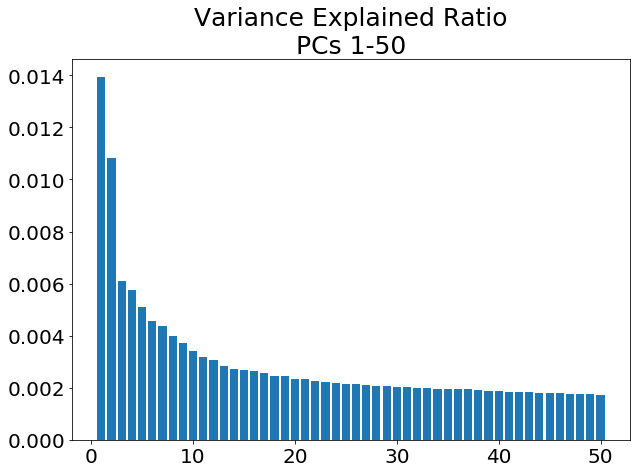

In [138]:
print(f'First PC explains {pca_model.explained_variance_ratio_[0]*100:.2f}% of the total variance.\nThis is an artifact of zero inflated T1 data')
plt.figure(figsize=(10, 7))
plt.bar(range(1, 51), pca_model.explained_variance_ratio_[1:51])
plt.title('Variance Explained Ratio\nPCs 1-50', fontsize=25)
plt.show()

In [11]:
train_T1_transformed = pca_model.transform(train_T1)
test_T1_transformed = pca_model.transform(test_T1)

## Fit Linear Regression Model 

In [188]:
# fast OLS using matrix math
# we will check that this matches sklearn results later

# fit ols model on dimension reduced train data
train_features = np.hstack([np.ones((train_T1_transformed.shape[0], 1)), 
                            train_T1_transformed])
train_features_inv = linalg.pinv2(train_features)
train_betas = np.dot(train_features_inv, train_phen)
train_pred_phen = np.dot(train_features, train_betas)

# fit ols model on dimension reduced test data
test_features = np.hstack([np.ones((test_T1_transformed.shape[0], 1)), 
                           test_T1_transformed])
test_pred_phen = np.dot(test_features, train_betas)

In [189]:
# OLS using sklearn

lr_model = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lr_model.fit(train_T1_transformed, train_phen)
train_pred_phen_lr_model = lr_model.predict(train_T1_transformed)
test_pred_phen_lr_model = lr_model.predict(test_T1_transformed)

In [190]:
# ensure matrix math predictions and sklearn predictions are accurate to 5 decimals
assert np.allclose(np.round(train_pred_phen - train_pred_phen_lr_model, 5), 0), 'Failed'
assert np.allclose(np.round(test_pred_phen - test_pred_phen_lr_model, 5), 0), 'Failed'
print('Passed')

Passed


## Accuracy of Predictions

In [192]:
train_r2 = metrics.r2_score(train_phen, train_pred_phen_lr_model)
train_mae = metrics.mean_absolute_error(train_phen, train_pred_phen_lr_model)
test_mae = metrics.mean_absolute_error(test_phen, test_pred_phen_lr_model)
train_mae = metrics.mean_squared_error(train_phen, train_pred_phen_lr_model)
test_mae = metrics.mean_squared_error(test_phen, test_pred_phen_lr_model)
print(f'Train R^2: {train_r2:.3f}')
print(f'Train MAE: {train_mae:.3f}')
print(f'Test MAE: {test_mae:.3f}')
print(f'Train MSE: {train_mae:.3f}')
print(f'Test MSE: {test_mae:.3f}')

Train R^2: 0.068
Train MAE: 2.980
Test MAE: 3.287


## BBS Cross Validation

In [16]:
def bbs(X, y, n_components, n_cv_splits, pred_summary_function, verbose=False):
    assert X.shape[0] == y.shape[0]
    
    fold_accs_train = []
    fold_accs_test = []
    np.random.seed(42)
    shuffled_idxs = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    for fold_i, test_idxs in enumerate(np.array_split(shuffled_idxs, n_cv_splits)):
        train_mask = np.ones(X.shape[0], np.bool)
        train_mask[test_idxs] = 0

        # create train/text X, y
        train_X, test_X = X[train_mask, :], X[test_idxs, :]
        train_y, test_y = y[train_mask], y[test_idxs]  

        # mean center columns using train data only
        train_X_mu = train_X.mean(axis=0)
        train_X = train_X - train_X_mu
        test_X = test_X - train_X_mu

        # fit pca
        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Fitting PCA model...')
        pca_model = decomposition.PCA(n_components=n_components).fit(train_X)

        # dimension reduce train/test data
        train_X = pca_model.transform(train_X)
        test_X = pca_model.transform(test_X)

        # fit OLS model
        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Fitting Linear Regression model...')
        lr_model = linear_model.LinearRegression(fit_intercept=True, normalize=False)
        lr_model.fit(train_X, train_y)

        train_pred = lr_model.predict(train_X)
        test_pred = lr_model.predict(test_X)

        fold_accs_train.append(pred_summary_function(train_y, train_pred))
        fold_accs_test.append(pred_summary_function(test_y, test_pred))
        
        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Train Accuracy: {round(fold_accs_train[-1], 3):<10} Test Accuracy: {round(fold_accs_test[-1], 3):<10}')

    
    plt.figure(figsize=(13, 7))
    plt.plot(range(1, len(fold_accs_train)+1), fold_accs_train, linestyle='-', marker='o', color='C0', label='Train CV Performance')
    plt.plot(range(1, len(fold_accs_test)+1), fold_accs_test, linestyle='-', marker='o', color='C1', label='Test CV Performance')
    plt.title(pred_summary_function.__name__, fontsize=20)
    plt.xticks(range(1, len(fold_accs_test)+1))
    plt.xlabel('CV Fold')
    plt.legend(fontsize=20)
    plt.show()
    
    return fold_accs_train, fold_accs_test

CV Fold: 1          Fitting PCA model...
CV Fold: 1          Fitting Linear Regression model...
CV Fold: 1          Train Accuracy: 2.989      Test Accuracy: 3.243     
CV Fold: 2          Fitting PCA model...
CV Fold: 2          Fitting Linear Regression model...
CV Fold: 2          Train Accuracy: 2.99       Test Accuracy: 3.118     
CV Fold: 3          Fitting PCA model...
CV Fold: 3          Fitting Linear Regression model...
CV Fold: 3          Train Accuracy: 3.01       Test Accuracy: 3.125     
CV Fold: 4          Fitting PCA model...
CV Fold: 4          Fitting Linear Regression model...
CV Fold: 4          Train Accuracy: 2.977      Test Accuracy: 3.125     
CV Fold: 5          Fitting PCA model...
CV Fold: 5          Fitting Linear Regression model...
CV Fold: 5          Train Accuracy: 2.936      Test Accuracy: 3.273     


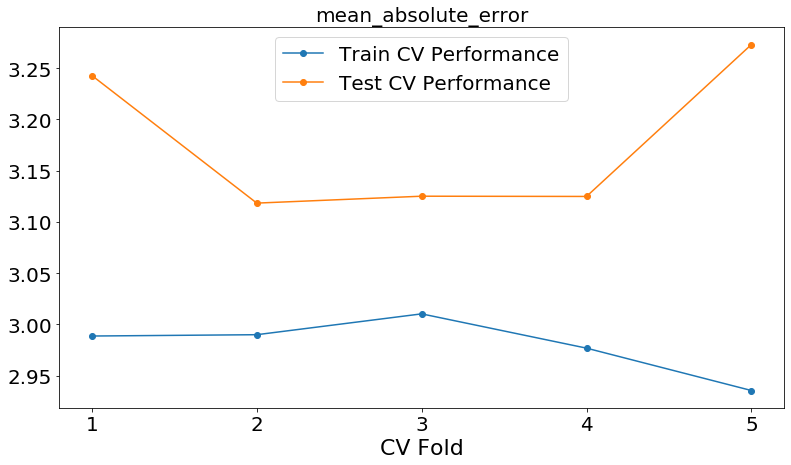

In [139]:
fold_accs_train, fold_accs_test = bbs(all_subs_T1_flat, ages, n_components=75, n_cv_splits=5, pred_summary_function=metrics.mean_absolute_error, verbose=True)

# Connectome Predictive Modelling 

In [27]:
# correlation train_brain with train_phenotype
train_pheno_corr_p = [stats.pearsonr(train_T1[:, i], train_phen) for i in range(train_T1.shape[1])]  # train_pheno_corr_p: (259200, )
# there are some nan correlations if brain data is poorly cropped (ie: some columns are always 0)

/home/ataxali/anaconda3/envs/sripada_lab/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [28]:
# split into positive and negative correlations 
# and keep edges with p values below threshold
pval_threshold = 0.01

train_corrs = np.array([x[0] for x in train_pheno_corr_p])
train_pvals = np.array([x[1] for x in train_pheno_corr_p])

keep_edges_pos = (train_corrs > 0) & (train_pvals < pval_threshold)
keep_edges_neg = (train_corrs < 0) & (train_pvals < pval_threshold)

/home/ataxali/anaconda3/envs/sripada_lab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/ataxali/anaconda3/envs/sripada_lab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/ataxali/anaconda3/envs/sripada_lab/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [43]:
print(f'number of positive edges kept = {np.sum(keep_edges_pos)}')
print(f'number of negative edges kept = {np.sum(keep_edges_neg)}')

number of positive edges kept = 677
number of negative edges kept = 73


In [48]:
train_pos_edges_sum = train_T1[:, keep_edges_pos].sum(1)
train_neg_edges_sum = train_T1[:, keep_edges_neg].sum(1)

In [52]:
fit_pos = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(train_pos_edges_sum.reshape(-1, 1), train_phen)
fit_neg = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(train_neg_edges_sum.reshape(-1, 1), train_phen)

In [61]:
pos_error = metrics.mean_absolute_error(train_phen, fit_pos.predict(train_pos_edges_sum.reshape(-1, 1)))
neg_error = metrics.mean_absolute_error(train_phen, fit_neg.predict(train_neg_edges_sum.reshape(-1, 1)))

print(f'Training Error (Positive Edges Model) = {pos_error:.3f}')
print(f'Training Error (Negative Edges Model) = {neg_error:.3f}')

Training Error (Positive Edges Model) = 2.973
Training Error (Negative Edges Model) = 2.884


In [64]:
# combine positive/negative edges in one linear regression model
fit_pos_neg = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(np.stack((train_pos_edges_sum, train_neg_edges_sum)).T, train_phen)

In [65]:
pos_neg_error = metrics.mean_absolute_error(train_phen, fit_pos_neg.predict(np.stack((train_pos_edges_sum, train_neg_edges_sum)).T))

print(f'Training Error (Positive/Negative Edges Model) = {pos_neg_error:.3f}')

Training Error (Positive/Negative Edges Model) = 2.156


In [67]:
# evaluate out of sample performance 
test_pos_edges_sum = test_T1[:, keep_edges_pos].sum(1)
test_neg_edges_sum = test_T1[:, keep_edges_neg].sum(1)

pos_test_error = metrics.mean_absolute_error(test_phen, fit_pos.predict(test_pos_edges_sum.reshape(-1, 1)))
neg_test_error = metrics.mean_absolute_error(test_phen, fit_neg.predict(test_neg_edges_sum.reshape(-1, 1)))
pos_neg_test_error = metrics.mean_absolute_error(test_phen, fit_pos_neg.predict(np.stack((test_pos_edges_sum, test_neg_edges_sum)).T))

print(f'Testing Error (Positive Edges Model) = {pos_test_error:.3f}')
print(f'Testing Error (Negative Edges Model) = {neg_test_error:.3f}')
print(f'Testing Error (Positive/Negative Edges Model) = {pos_neg_test_error:.3f}')

Testing Error (Positive Edges Model) = 3.391
Testing Error (Negative Edges Model) = 3.304
Testing Error (Positive/Negative Edges Model) = 3.464


## CPM Cross Validation

In [73]:
def cpm(X, y, p_threshold, n_cv_splits, pred_summary_function, verbose=False):
    assert X.shape[0] == y.shape[0]
    
    fold_accs_train = []
    fold_accs_test = []
    np.random.seed(42)
    shuffled_idxs = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    for fold_i, test_idxs in enumerate(np.array_split(shuffled_idxs, n_cv_splits)):
        train_mask = np.ones(X.shape[0], np.bool)
        train_mask[test_idxs] = 0

        # create train/text X, y
        train_X, test_X = X[train_mask, :], X[test_idxs, :]
        train_y, test_y = y[train_mask], y[test_idxs]  
        
        # create correlation matrix between train_X and train_y
        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Computing correlations between train_X and train_y...')
        with warnings.catch_warnings():
            # we expect pearsonr to throw PearsonRConstantInputWarning because of contant valued columns in X
            warnings.simplefilter("ignore")
            train_pheno_corr_p = [stats.pearsonr(train_X[:, i], train_y) for i in range(train_X.shape[1])]
            train_corrs = np.array([x[0] for x in train_pheno_corr_p])
            train_pvals = np.array([x[1] for x in train_pheno_corr_p])
            # create masks for edges below p-threshold and split pos/neg correlations
            keep_edges_pos = (train_corrs > 0) & (train_pvals < p_threshold)
            keep_edges_neg = (train_corrs < 0) & (train_pvals < p_threshold)
        
        # sum X entries with significant correlations with y
        train_pos_edges_sum = train_X[:, keep_edges_pos].sum(1)
        train_neg_edges_sum = train_X[:, keep_edges_neg].sum(1)
        test_pos_edges_sum = test_X[:, keep_edges_pos].sum(1)
        test_neg_edges_sum = test_X[:, keep_edges_neg].sum(1)
        
        # fit linear regression models based on summed values
        fit_pos = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(train_pos_edges_sum.reshape(-1, 1), train_y)
        fit_neg = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(train_neg_edges_sum.reshape(-1, 1), train_y)
        fit_pos_neg = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(np.stack((train_pos_edges_sum, train_neg_edges_sum)).T, train_y)
        
        # compute train errors
        train_pos_error = pred_summary_function(train_y, fit_pos.predict(train_pos_edges_sum.reshape(-1, 1)))
        train_neg_error = pred_summary_function(train_y, fit_neg.predict(train_neg_edges_sum.reshape(-1, 1)))
        train_posneg_error = pred_summary_function(train_y, fit_pos_neg.predict(np.stack((train_pos_edges_sum, train_neg_edges_sum)).T))

        # compute testing errors
        test_pos_error = pred_summary_function(test_y, fit_pos.predict(test_pos_edges_sum.reshape(-1, 1)))
        test_neg_error = pred_summary_function(test_y, fit_neg.predict(test_neg_edges_sum.reshape(-1, 1)))
        test_posneg_error = pred_summary_function(test_y, fit_pos_neg.predict(np.stack((test_pos_edges_sum, test_neg_edges_sum)).T))

        fold_accs_train.append((train_pos_error, train_neg_error, train_posneg_error))
        fold_accs_test.append((test_pos_error, test_neg_error, test_posneg_error))
        
        if verbose:
            print(f'CV Fold: {fold_i+1:<10} Train Pos-Edges Model Accuracy: {round(train_pos_error, 3):<10} Train Neg-Edges Model Accuracy: {round(train_neg_error, 3):<10} Train Pos/Neg-Edges Model Accuracy: {round(train_posneg_error, 3):<10}')
            print(f'CV Fold: {fold_i+1:<10} Test  Pos-Edges Model Accuracy: {round(test_pos_error, 3):<10} Test  Neg-Edges Model Accuracy: {round(test_neg_error, 3):<10} Test  Pos/Neg-Edges Model Accuracy: {round(test_posneg_error, 3):<10}')

    
    plt.figure(figsize=(13, 7))
    plt.plot(range(1, len(fold_accs_train)+1), [x[0] for x in fold_accs_train], linestyle='--', marker='o', color='C0', label='Train Pos-Edges Model')
    plt.plot(range(1, len(fold_accs_train)+1), [x[1] for x in fold_accs_train], linestyle='--', marker='o', color='C1', label='Train Neg-Edges Model')
    plt.plot(range(1, len(fold_accs_train)+1), [x[2] for x in fold_accs_train], linestyle='--', marker='o', color='C2', label='Train Pos/Neg-Edges Model')
    
    plt.plot(range(1, len(fold_accs_test)+1), [x[0] for x in fold_accs_test], linestyle='-', marker='o', color='C0', label='Test  Pos-Edges Model')
    plt.plot(range(1, len(fold_accs_test)+1), [x[1] for x in fold_accs_test], linestyle='-', marker='o', color='C1', label='Test  Neg-Edges Model')
    plt.plot(range(1, len(fold_accs_test)+1), [x[2] for x in fold_accs_test], linestyle='-', marker='o', color='C2', label='Test  Pos/Neg-Edges Model')
    
    plt.title(pred_summary_function.__name__, fontsize=20)
    plt.xticks(range(1, len(fold_accs_test)+1))
    plt.xlabel('CV Fold')
    plt.legend(fontsize=20)
    plt.show()
    
    return fold_accs_train, fold_accs_test

CV Fold: 1          Computing correlations between train_X and train_y...
CV Fold: 1          Train Pos-Edges Model Accuracy: 3.002      Train Neg-Edges Model Accuracy: 2.965      Train Pos/Neg-Edges Model Accuracy: 2.689     
CV Fold: 1          Test  Pos-Edges Model Accuracy: 3.195      Test  Neg-Edges Model Accuracy: 3.361      Test  Pos/Neg-Edges Model Accuracy: 3.374     
CV Fold: 2          Computing correlations between train_X and train_y...
CV Fold: 2          Train Pos-Edges Model Accuracy: 3.056      Train Neg-Edges Model Accuracy: 2.969      Train Pos/Neg-Edges Model Accuracy: 2.717     
CV Fold: 2          Test  Pos-Edges Model Accuracy: 3.043      Test  Neg-Edges Model Accuracy: 3.222      Test  Pos/Neg-Edges Model Accuracy: 3.202     
CV Fold: 3          Computing correlations between train_X and train_y...
CV Fold: 3          Train Pos-Edges Model Accuracy: 2.921      Train Neg-Edges Model Accuracy: 2.956      Train Pos/Neg-Edges Model Accuracy: 1.777     
CV Fold: 3   

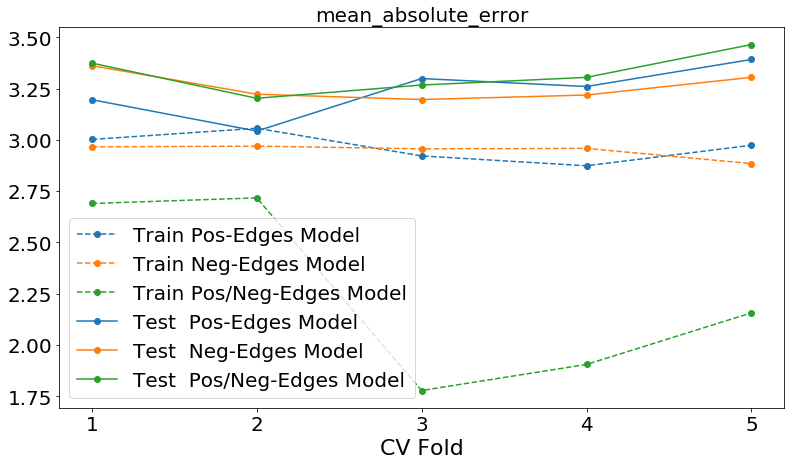

In [140]:
fold_accs_train, fold_accs_test = cpm(all_subs_T1_flat, ages, p_threshold=0.01, n_cv_splits=5, pred_summary_function=metrics.mean_absolute_error, verbose=True)

# Lasso (Linear Regression + L1 Regularization)

In [142]:
# LassoCV uses coordinate descent to select hyperparameter alpha 
alpha_grid = np.array([10**a for a in np.arange(-3, 3, 0.25)])
lassoCV_model = linear_model.LassoCV(cv=5, n_alphas=len(alpha_grid), alphas=alpha_grid, fit_intercept=True, normalize=False, random_state=42, verbose=True, n_jobs=5).fit(train_T1, train_phen)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
...........................................................................................................[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.1min
.............[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.5min finished


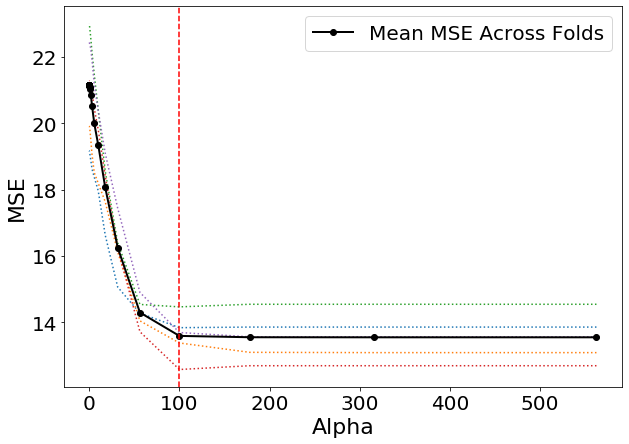

In [175]:
plt.figure(figsize=(10, 7))
plt.plot(lassoCV_model.alphas_, lassoCV_model.mse_path_, ':')
plt.plot(lassoCV_model.alphas_, lassoCV_model.mse_path_.mean(axis=-1), color='k', marker='o', label='Mean MSE Across Folds', linewidth=2)
plt.axvline(x=100, linestyle='--', c='r')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [148]:
# based on cv results above, set alpha=100
lasso_model = linear_model.Lasso(alpha=lassoCV_model.alpha_, fit_intercept=True, normalize=False).fit(train_T1, train_phen)

In [158]:
train_preds_lasso_model = lasso_model.predict(train_T1)
test_preds_lasso_model = lasso_model.predict(test_T1)

train_mae = metrics.mean_absolute_error(train_phen, train_preds_lasso_model)
test_mae = metrics.mean_absolute_error(test_phen, test_preds_lasso_model)

print(f'Train MAE: {train_mae:.3f}')
print(f'Test MAE: {test_mae:.3f}')

Train MAE: 3.064
Test MAE: 3.250


# Ridge (Linear Regression + L2 Regularization)

In [154]:
# RidgeCV uses generalized cross validation to select hyperparameter alpha 
with warnings.catch_warnings():
    # ignore matrix decomposition errors
    warnings.simplefilter("ignore")
    ridgeCV_model = linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=False, cv=5).fit(train_T1, train_phen)

In [162]:
ridge_alpha = ridgeCV_model.alpha_
print(f'CV Selected Alpha = {ridge_alpha:.3f}')

CV Selected Alpha = 0.100


In [163]:
ridge_model = linear_model.Ridge(alpha=ridge_alpha, fit_intercept=True, normalize=False).fit(train_T1, train_phen)

/home/ataxali/anaconda3/envs/sripada_lab/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [164]:
train_preds_ridge_model = ridge_model.predict(train_T1)
test_preds_ridge_model = ridge_model.predict(test_T1)

train_mae = metrics.mean_absolute_error(train_phen, train_preds_ridge_model)
test_mae = metrics.mean_absolute_error(test_phen, test_preds_ridge_model)

print(f'Train MAE: {train_mae:.3f}')
print(f'Test MAE: {test_mae:.3f}')

Train MAE: 0.001
Test MAE: 3.326


# Elastic Net (Linear Regression + L1/L2 Regularization)

In [178]:
# RidgeCV uses generalized cross validation to select hyperparameter alpha 
elasticnetCV_model = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_alphas=len(alpha_grid), alphas=alpha_grid, random_state=42, verbose=True, n_jobs=5).fit(train_T1, train_phen)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed: 33.5min finished


In [179]:
print(f'CV selected alpha {elasticnetCV_model.alpha_:.3f}')
print(f'Elastic net L1 ratio {elasticnetCV_model.l1_ratio_:.3f}')

CV selected alpha 562.341
Elastic net L1 ratio 0.500


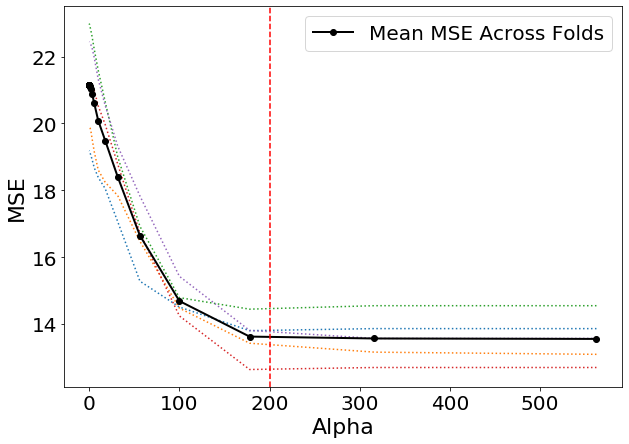

In [186]:
plt.figure(figsize=(10, 7))
plt.plot(elasticnetCV_model.alphas_, elasticnetCV_model.mse_path_[1, :, :], ':')
plt.plot(elasticnetCV_model.alphas_, elasticnetCV_model.mse_path_[1, :, :].mean(axis=-1), color='k', marker='o', label='Mean MSE Across Folds', linewidth=2)
plt.axvline(x=200, linestyle='--', c='r')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [187]:
elasticnet_model = linear_model.ElasticNet(alpha=elasticnetCV_model.alpha_, l1_ratio=elasticnetCV_model.l1_ratio_, fit_intercept=True, normalize=False, random_state=42).fit(train_T1, train_phen)

train_preds_en_model = elasticnet_model.predict(train_T1)
test_preds_en_model = elasticnet_model.predict(test_T1)

train_mae = metrics.mean_absolute_error(train_phen, train_preds_en_model)
test_mae = metrics.mean_absolute_error(test_phen, test_preds_en_model)

print(f'Train MAE: {train_mae:.3f}')
print(f'Test MAE: {test_mae:.3f}')

Train MAE: 3.116
Test MAE: 3.242
